In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

# 데이터 디렉토리 설정 (현재 ipynb 파일과 동일한 경로에 폴더가 있다고 가정)
data_dir = './'  # 현재 경로

In [2]:
# 이미지 크기와 배치 크기 설정
batch_size = 16
img_height = 224
img_width = 224


In [3]:
# 훈련 데이터셋 생성
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 데이터의 20%를 검증용으로 사용
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1000 files belonging to 4 classes.
Using 800 files for training.


In [4]:
# 검증 데이터셋 생성
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 데이터의 20%를 검증용으로 사용
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1000 files belonging to 4 classes.
Using 200 files for validation.


In [5]:
# 클래스 이름 출력
class_names = train_ds.class_names
print('클래스 이름:', class_names)

클래스 이름: ['Angry', 'Other', 'Sad', 'happy']


In [6]:
# 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:

# 데이터 증강 레이어 정의
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [8]:
# 이미지 패딩을 사용하여 크기 조정
def resize_with_padding(image, img_height, img_width):
    return tf.image.resize_with_pad(image, img_height, img_width)

# 예시: 데이터 증강 레이어에 추가
data_augmentation = keras.Sequential([
    layers.Lambda(lambda image: resize_with_padding(image, img_height, img_width)),  # 패딩 사용
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [9]:
# 사전 학습된 MobileNetV2 모델 불러오기
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

base_model.trainable = False  # 베이스 모델의 가중치 동결

# 분류를 위한 레이어 추가
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(len(class_names), activation='softmax')

# 전체 모델 구성
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = layers.Dropout(0.5)(x)  # 드롭아웃 레이어 추가
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [10]:
# 모델 컴파일
# 모델 컴파일 시 학습률 조정
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),  # 학습률 낮추기
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# 베스트 모델을 저장하기 위한 체크포인트 콜백 설정
checkpoint_filepath = 'best_model.keras'  # .keras 확장자로 파일 저장
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
# 모델 훈련
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.3132 - loss: 1.5177 - val_accuracy: 0.4500 - val_loss: 1.2850
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.5545 - loss: 1.0911 - val_accuracy: 0.5500 - val_loss: 1.0423
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.5998 - loss: 0.9377 - val_accuracy: 0.5950 - val_loss: 0.9669
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.7055 - loss: 0.8163 - val_accuracy: 0.6300 - val_loss: 0.8821
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.7483 - loss: 0.7191 - val_accuracy: 0.6600 - val_loss: 0.8293
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.7684 - loss: 0.6486 - val_accuracy: 0.7100 - val_loss: 0.7940
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.8109 - loss: 0.5882 - val_accuracy: 0.6550 - val_loss: 0.8500
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.8041 - loss: 0.5795 - val_acc

KeyboardInterrupt: 

In [13]:
import numpy as np
from sklearn.metrics import classification_report

# 검증 데이터셋에 대한 평가
test_loss, test_accuracy = model.evaluate(val_ds, verbose=0)
print(f'\n검증 데이터셋 정확도: {test_accuracy:.2f}')

# 검증 데이터셋에 대한 예측값 생성
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 실제 라벨과 예측 라벨 추출
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_labels = y_pred
y_true_labels = y_true

# 클래스 이름 (Angry, Happy, Sad, Other 등) 출력
print("\n분류 보고서:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))



검증 데이터셋 정확도: 0.88
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step

분류 보고서:
              precision    recall  f1-score   support

       Angry       0.88      0.86      0.87        50
       Other       0.93      0.90      0.92        63
         Sad       0.73      0.97      0.84        37
       happy       0.95      0.78      0.86        50

    accuracy                           0.88       200
   macro avg       0.87      0.88      0.87       200
weighted avg       0.89      0.88      0.88       200



In [16]:


import matplotlib.pyplot as plt

# 훈련 결과에서 정확도와 손실 값 불러오기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# 정확도와 손실 그래프 그리기
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='train accuracy')
plt.plot(epochs_range, val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('train and val accuracy')

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('train and val loss')

# 그래프 보여주기
plt.show()


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.9457 - loss: 0.2367 - val_accuracy: 0.8550 - val_loss: 0.4229
Epoch 2/100
11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9720 - loss: 0.1741

KeyboardInterrupt: 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


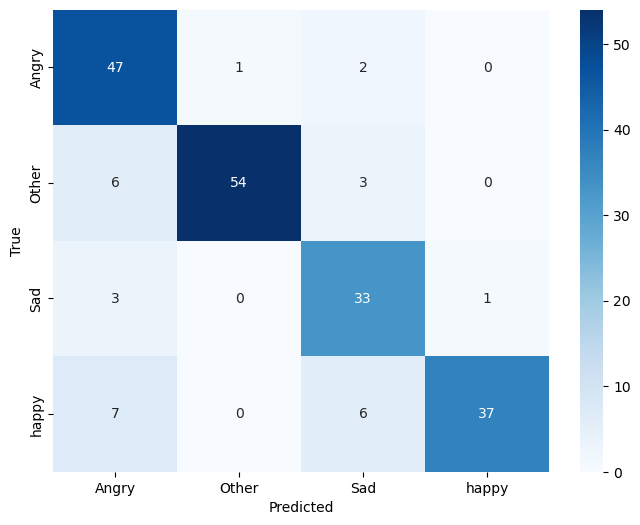

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 검증 데이터에 대한 예측값 생성
val_predictions = np.argmax(model.predict(val_ds), axis=1)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

# 혼동 행렬 생성
cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


테스트 데이터에 대한 예측 수행 중...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
예측 완료.
맞은 예측 개수: 171
틀린 예측 개수: 29
아깝게 틀린 예측 개수: 22


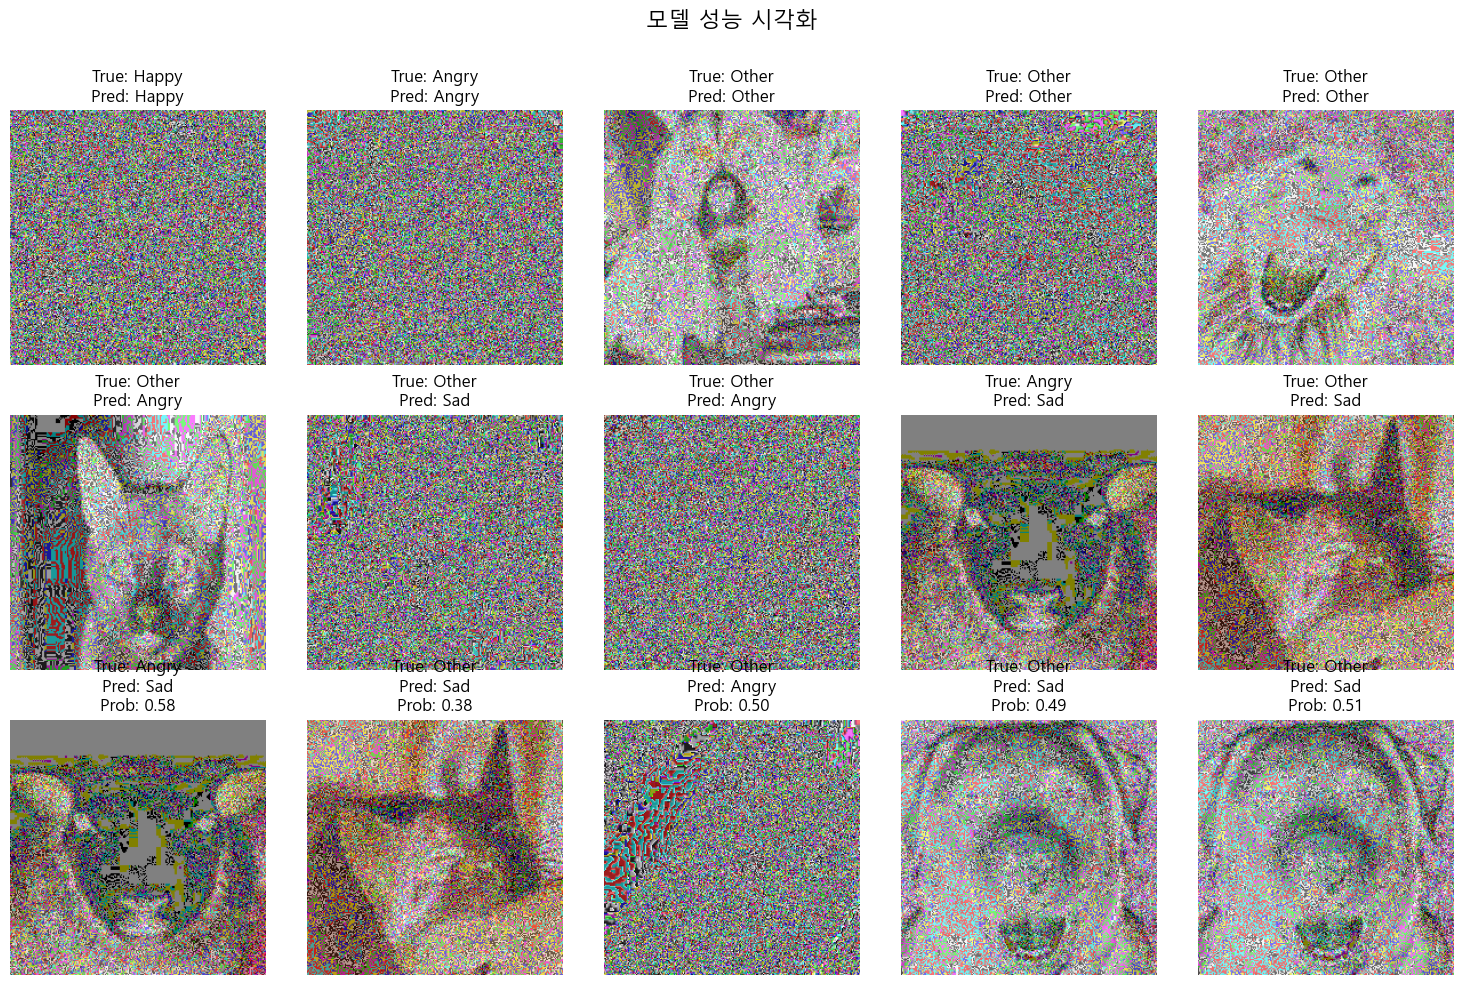

혼동 행렬:
[[47  1  2  0]
 [ 6 54  3  0]
 [ 3  0 33  1]
 [ 7  0  6 37]]


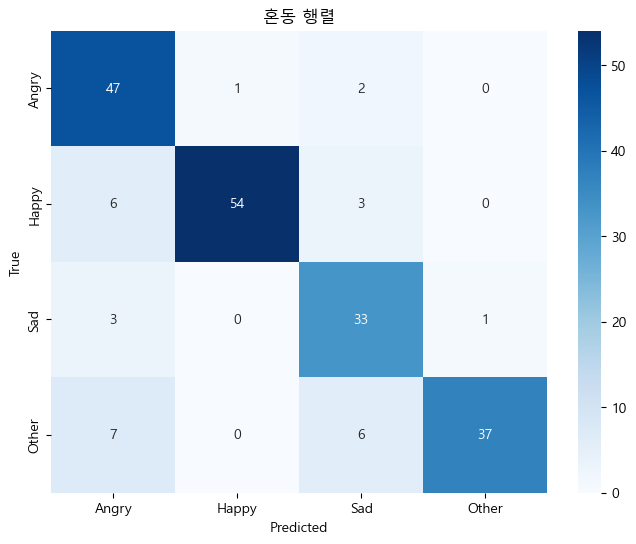

분류 보고서:
              precision    recall  f1-score   support

       Angry       0.75      0.94      0.83        50
       Happy       0.98      0.86      0.92        63
         Sad       0.75      0.89      0.81        37
       Other       0.97      0.74      0.84        50

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.88      0.85      0.86       200



In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import font_manager, rc
import platform
import cv2

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 '맑은 고딕'
elif platform.system() == 'Darwin':  # MacOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux (Ubuntu 등)
    plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# =============================
# 테스트 데이터에 대한 예측 수행
# =============================

print("테스트 데이터에 대한 예측 수행 중...")

all_images = []
all_labels = []
all_predictions = []
all_probabilities = []

# 테스트 데이터에 대한 예측 수행 (val_ds는 validation 데이터셋)
for images, labels in val_ds:
    # 모델 예측 (예측 확률)
    predictions = model.predict(images)
    
    # 확률이 가장 높은 클래스로 예측 라벨을 변환
    predicted_labels = np.argmax(predictions, axis=1)
    
    # 이미지, 실제 라벨, 예측 라벨, 확률을 리스트에 추가
    all_images.extend(images.numpy())  # 텐서를 넘파이 배열로 변환
    all_labels.extend(labels.numpy())
    all_predictions.extend(predicted_labels)
    all_probabilities.extend(np.max(predictions, axis=1))  # 예측 확률 중 가장 높은 값

print("예측 완료.")

# =============================
# 이미지와 라벨을 시각적으로 확인하는 함수 정의
# =============================

def plot_images(images, labels, predictions, probabilities, correct_indices, incorrect_indices, uncertain_indices, title):
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    class_names = ['Angry', 'Happy', 'Sad', 'Other']
    
    # 맞은 사진
    for i, idx in enumerate(correct_indices[:5]):
        ax = axes[0, i]
        # 이미지 데이터 타입 변환 및 BGR에서 RGB로 변환
        image_rgb = cv2.cvtColor(images[idx].astype(np.float32), cv2.COLOR_BGR2RGB)
        image_uint8 = (image_rgb * 255).astype(np.uint8)
        ax.imshow(image_uint8)
        ax.set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predictions[idx]]}")
        ax.axis('off')
    
    # 틀린 사진
    for i, idx in enumerate(incorrect_indices[:5]):
        ax = axes[1, i]
        image_rgb = cv2.cvtColor(images[idx].astype(np.float32), cv2.COLOR_BGR2RGB)
        image_uint8 = (image_rgb * 255).astype(np.uint8)
        ax.imshow(image_uint8)
        ax.set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predictions[idx]]}")
        ax.axis('off')
    
    # 아깝게 틀린 사진
    for i, idx in enumerate(uncertain_indices[:5]):
        ax = axes[2, i]
        image_rgb = cv2.cvtColor(images[idx].astype(np.float32), cv2.COLOR_BGR2RGB)
        image_uint8 = (image_rgb * 255).astype(np.uint8)
        ax.imshow(image_uint8)
        ax.set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predictions[idx]]}\nProb: {probabilities[idx]:.2f}")
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# =============================
# 결과 시각화
# =============================

# 맞은 사진, 틀린 사진, 아깝게 틀린 사진의 인덱스 구하기
correct_indices = [i for i in range(len(all_labels)) if all_labels[i] == all_predictions[i]]
incorrect_indices = [i for i in range(len(all_labels)) if all_labels[i] != all_predictions[i]]
uncertain_indices = [i for i in range(len(all_labels)) if abs(all_probabilities[i] - 0.5) < 0.2 and all_labels[i] != all_predictions[i]]

print(f"맞은 예측 개수: {len(correct_indices)}")
print(f"틀린 예측 개수: {len(incorrect_indices)}")
print(f"아깝게 틀린 예측 개수: {len(uncertain_indices)}")

# 결과 시각화
plot_images(
    all_images, all_labels, all_predictions, all_probabilities,
    correct_indices, incorrect_indices, uncertain_indices,
    "모델 성능 시각화"
)

# =============================
# 혼동 행렬 및 분류 보고서 출력
# =============================

class_names = ['Angry', 'Happy', 'Sad', 'Other']

# 혼동 행렬 계산
cm = confusion_matrix(all_labels, all_predictions)
print("혼동 행렬:")
print(cm)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
plt.title('혼동 행렬')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 분류 보고서 출력
report = classification_report(all_labels, all_predictions, target_names=class_names)
print("분류 보고서:")
print(report)
